In [230]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [193]:
datapath = f'IMDB Dataset.csv'
df = pd.read_csv(datapath)
df['label'] = 0
df.loc[df['sentiment']=='positive','label'] = 1
df.head()

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


<AxesSubplot:xlabel='sentiment'>

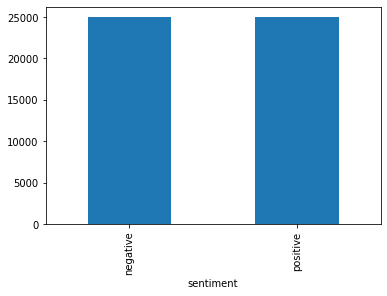

In [149]:
df.groupby(['sentiment']).size().plot.bar()

In [150]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'negative':0,
          'positive':1,
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['sentiment']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['review']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [151]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        return final_layer

    def forwardNoClassification(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        return pooled_output

In [152]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [153]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [154]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

40000 5000 5000


In [156]:
EPOCHS = 1
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 20000/20000 [41:18<00:00,  8.07it/s]


Epochs: 1 | Train Loss:  0.158 | Train Accuracy:  0.887 | Val Loss:  0.107 | Val Accuracy:  0.922


# wytrenowany bert

In [191]:
def makeDataset(df):
    texts = [tokenizer(text, 
                                padding='max_length', max_length = 512, truncation=True,
                                    return_tensors="pt") for text in df['review']]
    return torch.utils.data.DataLoader(texts)

In [275]:
dataset = Dataset(df_train)

In [281]:
device = "cuda"
clusteringData = []
iter = 0

for predict_input in dataset:
    mask = predict_input['attention_mask'][0].to(device)
    input_id = predict_input['input_ids'][0].to(device)

    model.cuda()
    output = model.forwardNoClassification(input_id[0], mask[0])
    clusteringData.append(output.cpu().detach().numpy().reshape(768))
    iter += 1
    if iter == 100:
        break

TypeError: tuple indices must be integers or slices, not str

In [ ]:
# # w miarę działa
# clustering = DBSCAN(eps=9, min_samples=3000).fit(clusteringData)
# clustering.labels_

# df['prediction'] = 0
# df['prediction'][0:iter] = clustering.labels_

# df[0:20]

In [ ]:
clustering = DBSCAN(eps=4, min_samples=40).fit(clusteringData)
clustering.labels_

df['prediction'] = 0
df['prediction'][0:iter] = clustering.labels_

df[0:20]

C:\Users\QbaSo\AppData\Local\Temp\ipykernel_11816\3857762723.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'][0:iter] = clustering.labels_


,review,sentiment,label,prediction
0,One of the other reviewers has mentioned that ...,positive,1,1
1,A wonderful little production. <br /><br />The...,positive,1,0
2,I thought this was a wonderful way to spend ti...,positive,1,1
3,Basically there's a family where a little boy ...,negative,0,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,1
5,"Probably my all-time favorite movie, a story o...",positive,1,0
6,I sure would like to see a resurrection of a u...,positive,1,0
7,"This show was an amazing, fresh & innovative i...",negative,0,1
8,Encouraged by the positive comments about this...,negative,0,1
9,If you like original gut wrenching laughter yo...,positive,1,1


(array([5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 5.299e+03,
        0.000e+00, 0.000e+00, 0.000e+00, 4.696e+03]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

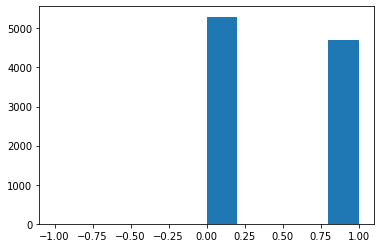

In [ ]:
plt.hist(clustering.labels_)